# 專題分析 - 台北市房價分析

# 1.資料匯入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文(for Mac)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊
pd.set_option("display.html.table_schema",True)
df_ml = pd.read_csv('tw_house.csv', encoding='big5') #台北市
df_ml.sample(5) #隨機取其中5筆資料

,鄉鎮市區,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
42,中正區,27.64,181.64,60559,4,2,2,0.00,0,36,70,105,1100.0,0,1,0,0,0,0,0,0,0,0,0,0
271,士林區,14.92,69.70,124534,2,2,2,0.00,0,39,67,106,868.0,0,0,0,0,0,0,1,0,0,0,0,0
23,內湖區,149.14,652.14,135784,0,0,0,99.48,0,5,101,105,8855.0,0,0,0,1,0,0,0,0,0,0,0,0
7,內湖區,16.90,133.73,160772,3,1,2,0.00,0,9,97,105,2150.0,0,0,0,1,0,0,0,0,0,0,0,0
407,北投區,31.25,214.19,207769,3,2,2,39.00,0,7,99,106,4450.0,0,0,0,0,1,0,0,0,0,0,0,0


# 2.檢查特徵相關性及線性關係

In [2]:
# 把DataFrame加上highlight背景色-凸顯要注意的feature
def highlight_highcorr(s):
    is_high = ((s >= 0.6) & (s < 1)) #Series condition setting
    return ['background-color: yellow' if v else '' for v in is_high]

## 2-1.相關性分析

In [3]:
df_ml.corr().round(3).style.apply(highlight_highcorr)

,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
土地移轉總面積平方公尺,1,0.678,0.069,0.34,0.22,0.242,0.39,0.348,-0.068,0.068,-0.009,0.515,-0.207,-0.107,0.039,0.157,0.06,0.08,0.121,-0.081,-0.056,0.116,-0.049,-0.109
建物移轉總面積平方公尺,0.678,1,0.272,0.197,0.06,0.153,0.736,0.625,-0.411,0.411,-0.083,0.862,-0.092,-0.021,0.033,0.121,0.018,0.092,0.062,-0.03,-0.001,-0.003,-0.058,-0.132
單價每平方公尺,0.069,0.272,1,-0.081,-0.007,0.018,0.26,0.368,-0.362,0.362,-0.046,0.567,0.056,0.05,0.084,-0.05,-0.13,0.006,0.04,-0.067,0.317,-0.125,0.096,-0.203
建物現況格局-房,0.34,0.197,-0.081,1,0.675,0.755,0.032,-0.008,0.097,-0.097,-0.041,0.069,-0.084,-0.117,-0.036,0.122,-0.039,0.017,0.021,-0.01,0.016,0.073,0.024,-0.022
建物現況格局-廳,0.22,0.06,-0.007,0.675,1,0.582,-0.043,-0.08,0.046,-0.046,-0.006,-0.015,-0.046,-0.15,-0.06,0.069,-0.031,0.028,0.052,-0.019,0.048,0.071,0.052,-0.04
建物現況格局-衛,0.242,0.153,0.018,0.755,0.582,1,0.015,-0.012,-0.031,0.031,-0.084,0.067,-0.011,-0.121,0.007,0.081,-0.035,0.034,0.039,-0.037,0.042,0.049,-0.032,-0.058
車位移轉總面積平方公尺,0.39,0.736,0.26,0.032,-0.043,0.015,1,0.739,-0.464,0.464,-0.086,0.631,-0.041,-0.049,0.005,0.101,0.066,0.053,0.046,-0.023,-0.016,0.014,-0.094,-0.106
車位總價元,0.348,0.625,0.368,-0.008,-0.08,-0.012,0.739,1,-0.359,0.359,-0.053,0.683,0.017,-0.021,-0.01,0.007,0.053,0.027,0.09,-0.031,-0.013,-0.012,-0.045,-0.087
屋齡,-0.068,-0.411,-0.362,0.097,0.046,-0.031,-0.464,-0.359,1,-1,0.143,-0.403,-0.068,0.003,0.091,-0.097,-0.076,-0.12,0.113,-0.005,0.019,-0.105,0.155,0.149
建築完成年,0.068,0.411,0.362,-0.097,-0.046,0.031,0.464,0.359,-1,1,-0.143,0.403,0.068,-0.003,-0.091,0.097,0.076,0.12,-0.113,0.005,-0.019,0.105,-0.155,-0.149


## 2-2.散佈圖矩陣

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b7994a8>,
      dtype=object)

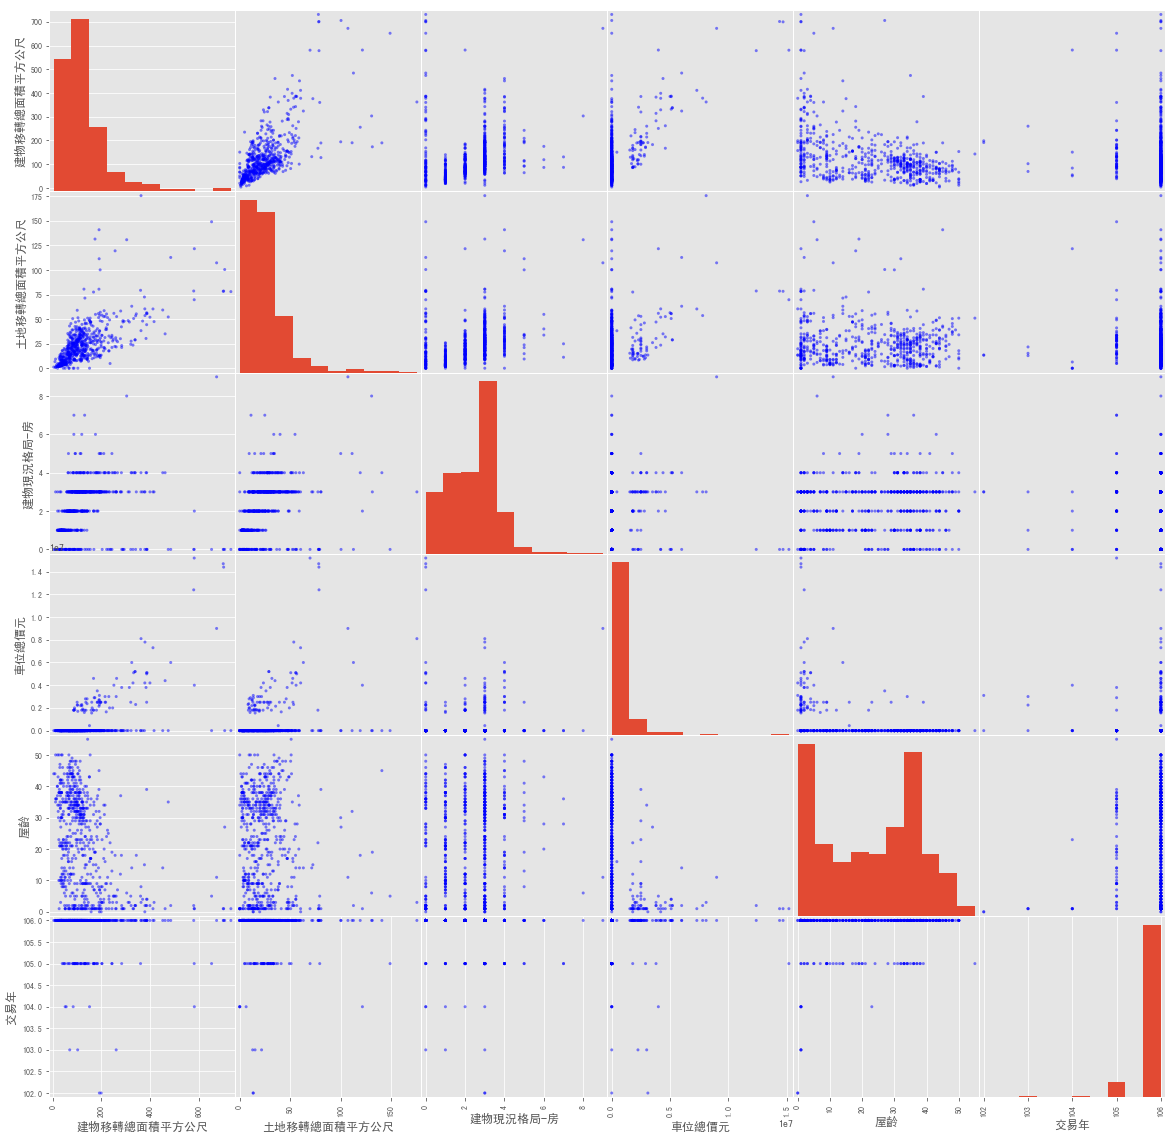

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_ml[['建物移轉總面積平方公尺','土地移轉總面積平方公尺',
                      '建物現況格局-房','車位總價元','屋齡','交易年']],figsize=(20, 20),color='b')

# 3.資料預處理 - 機器學習

## 3-1.切分訓練及測試資料 

In [5]:
from sklearn.model_selection import train_test_split

X = df_ml[['建物移轉總面積平方公尺','土地移轉總面積平方公尺','單價每平方公尺','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','車位移轉總面積平方公尺','車位總價元','屋齡','建築完成年','交易年','中山區','中正區','信義區','內湖區','北投區','南港區','士林區','大同區','大安區','文山區','松山區','萬華區']]
y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,建物移轉總面積平方公尺,土地移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
238,87.93,16.50,161492,2,2,1,0.00,0,35,71,106,1,0,0,0,0,0,0,0,0,0,0,0
414,194.63,48.31,161846,3,2,2,14.47,0,2,104,106,0,0,0,0,1,0,0,0,0,0,0,0
511,66.08,34.00,75666,2,1,1,0.00,0,50,56,106,0,0,0,0,1,0,0,0,0,0,0,0
45,132.11,22.81,122616,2,2,1,43.42,0,9,97,105,0,0,0,0,0,0,0,0,0,1,0,0
433,180.41,11.58,195665,3,2,2,0.00,0,24,82,106,0,0,1,0,0,0,0,0,0,0,0,0


## 3-2.標準化 

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)

## 3-3.產生高次方項 

In [7]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2) #0~2次方

X_train_poly = quadratic.fit_transform(X_train_std)
X_test_poly = quadratic.fit_transform(X_test_std) 
X_poly = quadratic.fit_transform(X_std)

## 3-3.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

In [8]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


# 4.使用線性迴歸演算法進行專題分析

## 4-1.多變項 - LinearRegression - All Features

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_std, y_train)

print('各變項參數:', lr.coef_)
print("MSE: %.2f" % np.mean((lr.predict(X_test_std) - y_test) ** 2))
print("R Square:",lr.score(X_test_std, y_test))


lr = LinearRegression()
lr.fit(X_train_poly, y_train)


各變項參數: [[ 2.02701224e+03 -1.28129974e+02  8.72116078e+02 -1.13024837e+01
  -3.11960303e+01 -3.06476205e+01 -4.47717798e+02  5.23475426e+02
   5.67962702e+01 -5.67962702e+01 -1.69481802e+01 -8.08634242e+00
   2.60029207e+01 -8.72080057e+01 -4.35836821e+01  1.94189606e+01
  -1.97511030e+00  8.62407439e+01 -1.39438813e+01  2.53109073e+01
   2.81328193e+01 -6.19942190e+01  4.17000567e+01]]
MSE: 973886.17
R Square: 0.8845785623313261


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## 4-2.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

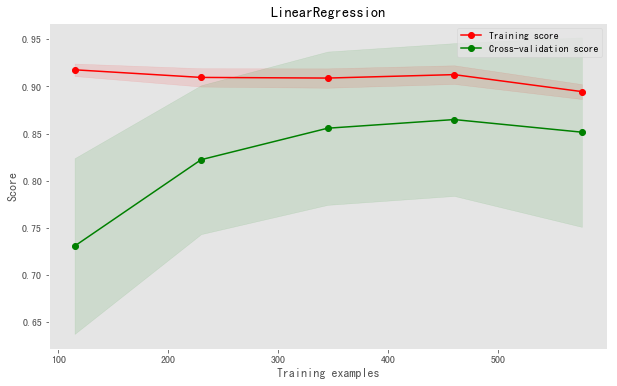

In [10]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = LinearRegression()

plot_learning_curve(estimator, "LinearRegression", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 4-3.非線性 - LinearRegression - All Features - 透過產生高次方項

In [11]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

print('各變項參數:', lr.coef_)
print("MSE: %.2f" % np.mean((lr.predict(X_test_poly) - y_test) ** 2))
print("R Square:",lr.score(X_test_poly, y_test))

各變項參數: [[ 1.92921648e+08  1.71556740e+03 -3.56851493e+00  8.22237122e+02
   1.84597674e+00  1.15659332e+01  1.45146880e+00 -1.18239276e+02
   1.63673923e+12  3.26975451e+13  3.26975451e+13 -1.40805125e+13
   2.73704717e+13  1.61255286e+13  5.12792173e+12 -1.39319718e+13
   1.85704840e+13  8.53825646e+12 -6.27865147e+12  4.52217827e+12
  -1.33066791e+13  8.85820231e+12  9.99375666e+12 -1.23472856e+13
   8.18362427e+00 -1.56607666e+01  7.15371886e+02 -1.36588135e+01
  -4.21548653e+00  3.16125031e+01  4.69909096e+01 -9.25798492e+01
   3.09015592e+11  3.09015592e+11 -4.01316643e+00 -3.57722025e+11
  -2.34655247e+11 -2.47453580e+11 -3.89598082e+11 -2.97973569e+11
  -2.16079550e+11 -2.74346314e+11 -1.89710752e+11 -2.39019306e+11
  -2.91507785e+11 -2.74346314e+11 -2.81392070e+11  4.11987305e-01
   3.43157196e+00  2.56623840e+00 -3.17807770e+00  2.15118408e-01
  -2.94855356e+01  2.97506943e+01 -1.26112355e+12 -1.26112355e+12
   1.40097046e+00  2.01519586e+12  1.32190989e+12  1.39400818e+12
   

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

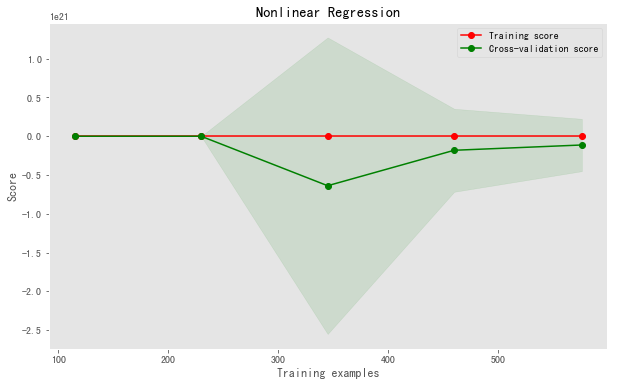

In [12]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = LinearRegression()

plot_learning_curve(estimator, "Nonlinear Regression", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

# 5.脊迴歸(Ridge Regression): L2 正規化

Linear Regression With L2 的正規化

## 5-1.多變項

In [13]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_std, y_train)

print('各變項參數:', ridge.coef_)
print("MSE: %.2f" % np.mean((ridge.predict(X_test_std) - y_test) ** 2))
print("R Square:",ridge.score(X_test_std, y_test))

各變項參數: [[ 2.00599073e+03 -1.16604974e+02  8.68794628e+02 -1.03093414e+01
  -3.25895109e+01 -2.97805685e+01 -4.36387462e+02  5.22758451e+02
   5.45097511e+01 -5.45097511e+01 -1.73367341e+01 -7.47698993e+00
   2.77439419e+01 -8.62930215e+01 -4.47222816e+01  1.76520340e+01
  -1.84507998e+00  8.60151938e+01 -1.39072618e+01  2.71704419e+01
   2.57407697e+01 -6.00781060e+01  4.12421605e+01]]
MSE: 981706.46
R Square: 0.8836517291278058


## 5-2.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

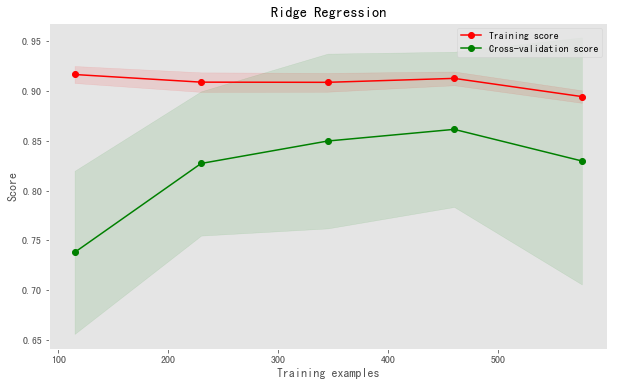

In [14]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Ridge(alpha=1)

plot_learning_curve(estimator, "Ridge Regression", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 5-3.Linear Regression With L2 - 產生高次方項 

In [15]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_poly, y_train)

print('各變項參數:', ridge.coef_)
print("MSE: %.2f" % np.mean((ridge.predict(X_test_poly) - y_test) ** 2))
print("R Square:",ridge.score(X_test_poly, y_test))

各變項參數: [[ 0.00000000e+00  1.63200462e+03  3.22095718e+01  8.11472569e+02
   1.35214008e+01  8.44139326e+00  9.69912673e+00 -1.01978387e+02
  -2.08098840e+02 -2.10141279e+01  2.10141279e+01  1.76349817e+01
  -8.33315131e-01  5.82424293e-01 -1.22120251e-01  5.72298348e-01
  -7.26257996e-01  2.77280486e-01 -1.51076491e-01 -1.80723801e-01
   6.80482100e-01 -1.30840434e+00 -8.74662518e-01  2.34414821e+00
   2.97858061e+01 -2.66175690e+01  6.71663011e+02  5.49672286e+00
   3.60469448e+00  2.76775465e-01  1.26980700e+01 -8.09832601e+01
  -1.88861766e+01  1.88861766e+01  1.46028839e+01  1.69502672e+01
   1.06006057e+01 -2.40195245e+00 -3.14175328e+00 -2.74966226e+01
  -2.00172703e-01 -2.15439512e+01 -1.25161043e+01  4.89094147e+01
  -6.35608650e+00  6.33855479e+00 -6.35241958e+00 -2.94307465e+00
   1.90655465e+01 -4.25822671e+00 -3.96457039e+00  3.69202781e+00
  -6.87360799e+00  2.51757198e+01  3.90920719e+00 -3.90920719e+00
   7.67065170e-01 -8.85067451e+00  7.84184984e+00 -9.92550929e-01
   

# 5-4.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

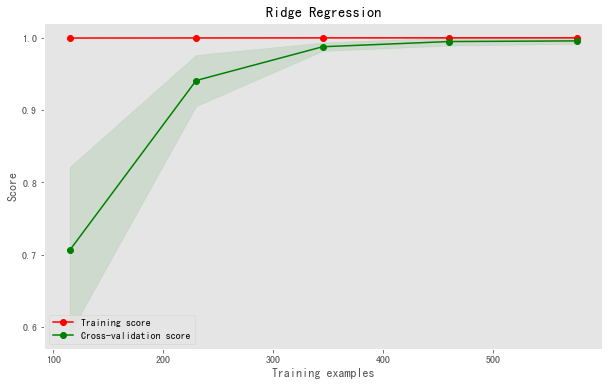

In [16]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Ridge(alpha=1)

plot_learning_curve(estimator, "Ridge Regression", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

# 6.LASSO: L1 正規化

Linear Regression With L1 的正規化

## 6-1.多變項 

In [17]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1)
lasso.fit(X_train_std, y_train)

print('各變項參數:', lasso.coef_)
print("MSE: %.2f" % np.mean((lasso.predict(X_test_std) - y_test.values.ravel()) ** 2))
print("R Square:",lasso.score(X_test_std, y_test))

各變項參數: [ 2.01813697e+03 -1.22195566e+02  8.70331330e+02 -1.06877690e+01
 -3.14397992e+01 -2.99593051e+01 -4.40779993e+02  5.20375916e+02
  1.10261762e+02 -1.29927815e-13 -1.54882934e+01 -1.54951746e+01
  2.03090656e+01 -9.20534205e+01 -5.29709385e+01  1.02698357e+01
 -6.70698867e+00  7.86926221e+01 -1.76109750e+01  1.93101904e+01
  1.86848171e+01 -6.68248112e+01  3.38403511e+01]
MSE: 975820.65
R Square: 0.8843492938743474


## 6-2.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not conver

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

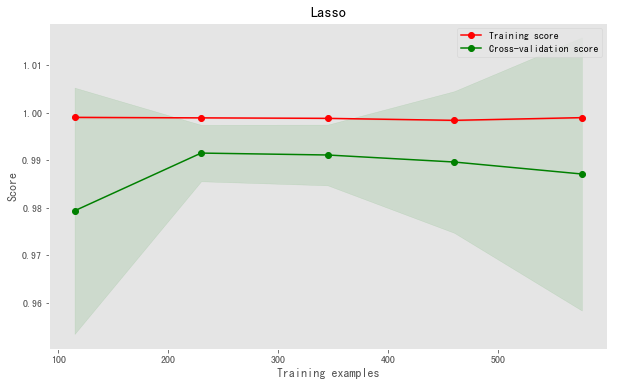

In [18]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Lasso(alpha=10)

plot_learning_curve(estimator, "Lasso", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 6-3.Linear Regression With L1 - 產生高次方項 

In [19]:
lasso = Lasso(alpha=5)
lasso.fit(X_train_poly, y_train)

print('各變項參數:', lasso.coef_)
print("MSE: %.2f" % np.mean((lasso.predict(X_test_poly) - y_test.values.ravel()) ** 2))
print("R Square:",lasso.score(X_test_poly, y_test))

各變項參數: [ 0.00000000e+00  1.72300635e+03  2.75954214e+00  8.15495331e+02
  6.46437298e-01  0.00000000e+00  0.00000000e+00 -6.35789561e+01
 -1.30570080e+02  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.01407660e+00  0.00000000e+00  7.01174077e+02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.26421109e+01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.00130594e-02 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -

## 6-4.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

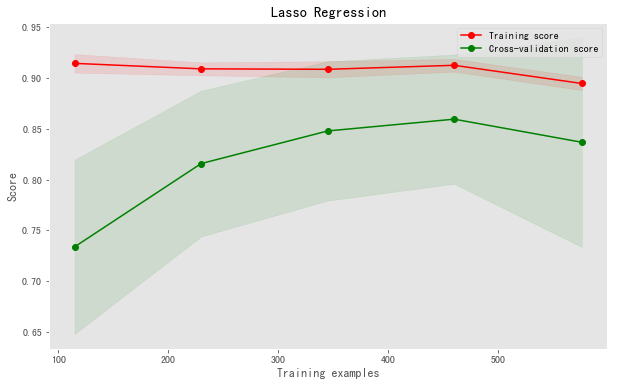

In [20]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = Lasso(alpha=1)

plot_learning_curve(estimator, "Lasso Regression", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

# 7.Elastic Net: L1+L2 正規化

Linear Regressuin With Both 正規化

## 7-1.多變項 

In [21]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=1)
elastic.fit(X_train_std, y_train)

print('各變項參數:', elastic.coef_)
print("MSE: %.2f" % np.mean((elastic.predict(X_test_std) - y_test.values.ravel()) ** 2))
print("R Square:",elastic.score(X_test_std, y_test))

各變項參數: [859.73652945 326.44974636 554.3708626   32.67878736 -49.78669228
   4.85312496 158.96163025 445.9064547  -81.07650225  81.07384481
 -30.53935315  -2.42652331  82.75279484 -11.3233376  -62.85408943
 -59.54005171  11.638874    71.8145176  -22.41827226 117.35026486
 -74.59028103  25.91190117 -14.48576649]
MSE: 1997417.50
R Square: 0.7632733606112133


## 7-2.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)  

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

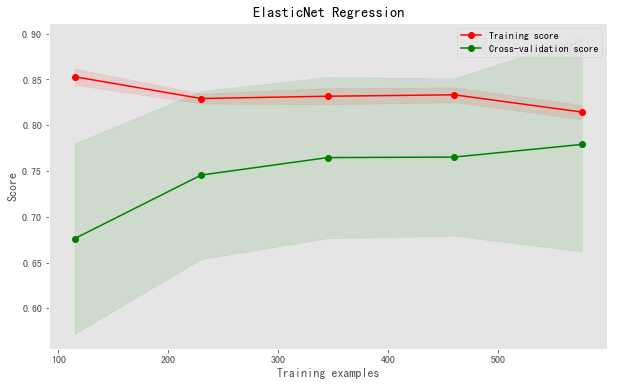

In [22]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = ElasticNet(alpha=1)

plot_learning_curve(estimator, "ElasticNet Regression", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 7-3.Linear Regression With Both - 產生高次方項 

In [23]:
elastic = ElasticNet(alpha=5)
elastic.fit(X_train_poly, y_train)

print('各變項參數:', elastic.coef_)
print("MSE: %.2f" % np.mean((elastic.predict(X_test_poly) - y_test.values.ravel()) ** 2))
print("R Square:",elastic.score(X_test_poly, y_test))

各變項參數: [ 0.00000000e+00  1.79443020e+02  1.05254786e+02  1.44272635e+02
  6.89058272e+01  5.35480492e+01  5.70729743e+01  6.83385499e+01
  4.54608222e+01 -9.35333851e+01  9.35333982e+01 -2.24098891e+00
 -1.09825137e+00  5.17493594e+00  1.59748895e+00 -0.00000000e+00
 -4.97085598e+00  5.25918883e+00 -1.32190891e+00 -1.20590806e+00
  1.42118115e+01 -5.21837982e+00  6.81840314e+00 -1.23990382e+01
  1.39823854e+02  2.39072064e+01  1.29834222e+02 -1.08777460e+01
 -4.06363357e+01 -1.28349136e+01  2.89816975e+01  6.21666275e+01
 -3.99021107e+01  3.99018781e+01  6.82368130e+00 -2.59149852e+00
  8.70847350e+01 -1.68125055e+01 -2.52232022e+01 -1.50671366e+01
  3.14298121e+00 -6.53706313e+00 -1.99670132e+01  6.01808783e+01
 -2.54395755e+01  1.20302864e+01 -1.78833244e+01  4.43896107e+01
  4.27752563e+01 -2.53694071e+01 -2.28092001e+01 -1.63285896e+01
 -1.59089897e+01  7.89640229e+00 -4.31425429e-01  4.31414281e-01
  6.38309664e+00 -6.12194092e+00  2.67020004e+01 -7.59635859e+00
 -7.12571755e-01 -

## 7-4.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)  

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

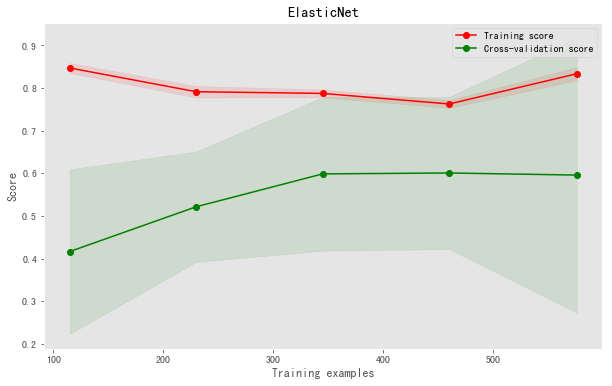

In [24]:
cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = ElasticNet(alpha=10)

plot_learning_curve(estimator, "ElasticNet", X_poly, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 結論 

#### 針對同樣也是分析台北市房價的W1-Homework進行比較與彙整

1.很顯然在W1-Homework中,即使透過相關性分析找出特徵值,仍無法有效將R Square提升至0.9以上

2.假設在特徵值足夠的狀況下仍無法有效提升預測值可思考進行正規化的處理

3.進行三種正規化的方法分析後得出L1正規化後透過高次方項的產生得出較高的分析結果

4.依據第三點的結論,可嘗試將新的測試資料放入模型中進行再次建模與預測得到是否為最適當的預測模型

5.此份分析需透過正規化方能得出較佳的預測結果